In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ
from timeit import timeit
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
)
from itertools import chain
import colorama
from colorama import Fore, Style

matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

In [2]:
def getdata():
    data = pd.read_csv("feature_vectors.csv").to_numpy()
    labels = pd.read_csv("diagnosis_label.csv").to_numpy().squeeze()
    labelscenter = pd.read_csv("center_label.csv").to_numpy().squeeze()

    labelsfinal = labels + labelscenter
    
    # better way to perform this
    labelsdiseases1 = np.where(labelsfinal == 'HCUMCG') 
    centerlabels1 = labelsfinal[labelsdiseases1]
    labelsdiseases2 = np.where(labelsfinal == 'HCUGOSM') 
    #labelsdiseases = np.where(labels == 'HCCUN','1',centerlabels) 
    centerlabels2 = labelsfinal[labelsdiseases2]
    labelsdiseases3 = np.where(labelsfinal == 'HCCUN') 
    centerlabels3 = labelsfinal[labelsdiseases3]
    
    # better way to perform this
    centerlabels = np.concatenate((centerlabels1,centerlabels2,centerlabels3))
    centerdata = data[labelsdiseases1]
    centerdata = np.concatenate((centerdata,data[labelsdiseases2]))
    centerdata = np.concatenate((centerdata,data[labelsdiseases3]))
    
    scaler = StandardScaler()
    data = ztransform(data,scaler)
    centerdata= ztransform(centerdata,scaler)
    return data,labels,centerdata,centerlabels,scaler

In [3]:
def ztransform(data_ztransform,scaler):
    # Sklearn's standardscaler to perform z-transform

    # Compute (fit) and apply (transform) z-transform
    # why do we do an inverse z transform
    scaler1 = scaler
    data_ztransform = scaler1.fit_transform(data_ztransform)
    
    return data_ztransform

In [4]:
def model_definition_center():
    
    model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
    solver_type="sgd",
    solver_params={"max_runs": 20,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,)
    
    return model

In [5]:
def model_definition_disease(correctionmatrix):
    model1 = GMLVQ(
        distance_type="adaptive-squared-euclidean",
        activation_type="sigmoid",
        activation_params={"beta": 2},
        solver_type="sgd",
        solver_params={"max_runs": 20,"batch_size":1,"step_size": np.array([0.1, 0.05])},
        random_state=1428,
        relevance_correction=correctionmatrix
    )
    return model1

In [6]:
def train_modelkfold(data, label,disease,correctionmatrix,repeated,folds=5):
    modelmatrix = np.zeros((repeated,folds),dtype=object) 
    accuracies = np.zeros((repeated,folds),dtype=float) 
    transformed_model_matrix = np.zeros((repeated,folds),dtype=object) 
    transformed_data_matrix = np.zeros((repeated,folds),dtype=int)
    
    if disease==False:
        print('Repeated K fold for center data')
    else:
        print('Repeated K fold for disease data')
    for repeated in range(repeated):
        print("========Repeated fold number",str(repeated),"========")
        kfold = KFold(folds, shuffle=True)
        for k, (training_indices, testing_indices) in enumerate(kfold.split(data)):
            if disease==False:
                model = model_definition_center()
                #print('in this')
                #print(type(model))
            else:
                model = model_definition_disease(correctionmatrix)
            accuracy = 0
            correct = 0
            trainX, trainY, testX, testY = data[training_indices], label[training_indices], data[testing_indices], label[testing_indices]
            #trainX = ztransform(trainX)
            #print(np.shape(trainX))
            model.fit(trainX, trainY)
            #validation accuracy
            # could use model.predict but it will only give the fraction of the correctly predicted labels
            #_, accuraccy = model.evaluate(testX, testY)
            predictedlabels = model.predict(testX)

            # since no model.evaluate.....

            for i in range(len(predictedlabels)):
                if(predictedlabels[i]==testY[i]):
                    correct = correct+1

            accuracy = correct/len(testY)
            print('%.3f accuracy' % (correct/len(testY)))
            
            # stored row wise
            modelmatrix[repeated,k] = model
        #histories.append(history_kfold)
    return modelmatrix

In [7]:
def calculate_lambda(modelmatrix,repeated):
    #average_lambda = np.mean(sum(model.lambda_ for model in modellist),axis=0)
    #check the shape of total_lambda
    
    total_lambda = np.zeros((36,36),dtype = 'float')
    print(repeated)
    for index in range(repeated):
        print(index)
        lambdaperfold = np.zeros((36,36),dtype='float')        
        
        for modelin in modelmatrix[index,:]:
            lambdaperfold = lambdaperfold + modelin.lambda_

        lambdaperfold = lambdaperfold/np.shape(modelmatrix)[1]
        
        total_lambda = total_lambda + lambdaperfold
        
    total_lambda = total_lambda/repeated

    return total_lambda

In [8]:
def eigendecomposition(average_lambda):
    eigenvalues, eigenvectors = np.linalg.eigh(average_lambda)
    # eigen vectors returned in columns
    # Flip (reverse the order to descending) before assigning.
    eigenvalues = np.flip(eigenvalues)

    # eigenvectors are column matrix in ascending order. Flip the columns and transpose the matrix
    # to get the descending ordered row matrix.
    
    # eigenvectors are row matrices
    eigenvectors = np.flip(eigenvectors, axis=1).T
    
    return eigenvalues,eigenvectors

In [9]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


In [10]:

def correction_matrix(eigenvectors):
    N=36
    K=3
    I = np.identity(N)
    outerproduct = np.zeros((N,N))   
    for i in range(K):
        # check this
        outerproduct +=  np.outer(eigenvectors[i,:],eigenvectors[i,:].T)
        print(np.shape(outerproduct))
        
    correctionmatrix = I-outerproduct
    return correctionmatrix

In [11]:
# check if this is the right label for disease
data,labels,centerdata,centerlabels,scalar = getdata()

centermodel = train_modelkfold(centerdata,centerlabels,False,None,2)

average_lambda_center = calculate_lambda(centermodel,2)

print('                                                     ')


print('The sum of the digonal of the center relevance matrix')

print(np.sum(np.diagonal(average_lambda_center)))

print('                                                     ')


eigenvaluescenter,eigenvectorscenter = eigendecomposition(average_lambda_center)


correctionmatrix = correction_matrix(eigenvectorscenter)

#correctionmatrix = correction_matrix()


Repeated K fold for center data
========Repeated fold number 0 ========
0.941 accuracy
0.941 accuracy
0.938 accuracy
0.938 accuracy
0.688 accuracy
========Repeated fold number 1 ========
0.941 accuracy
0.882 accuracy
0.938 accuracy
0.938 accuracy
0.938 accuracy
2
0
1
                                                     
The sum of the digonal of the center relevance matrix
0.9999999999999999
                                                     
(36, 36)
(36, 36)
(36, 36)


In [12]:

diseasemodel = train_modelkfold(data,labels,True,correctionmatrix,2)

average_lambda_disease = calculate_lambda(diseasemodel,2)

eigenvaluesdisease,eigenvectorsdisease = eigendecomposition(average_lambda_disease)




print('The sum of the digonal of the disease relevance matrix')

print(np.sum(np.diagonal(average_lambda_disease)))


Repeated K fold for disease data
========Repeated fold number 0 ========
0.716 accuracy
0.701 accuracy
0.636 accuracy
0.727 accuracy
0.652 accuracy
========Repeated fold number 1 ========
0.731 accuracy
0.687 accuracy
0.848 accuracy
0.682 accuracy
0.758 accuracy
2
0
1
The sum of the digonal of the disease relevance matrix
1.0


In [14]:
first_eigen_vector = np.dot(eigenvectorsdisease[0,:],eigenvectorscenter[0,:])
print(first_eigen_vector)

-3.469446951953614e-18


In [15]:
def check_orthogonality(centermodel,diseasemodel,dimensions,repeated,folds,eigenvectorscenter):
    centerlist = list(chain.from_iterable(zip(*centermodel)))
    disease_center = list()
    disease_averagecenter= list()
    for j in range(2):
        for array,modeld in enumerate(diseasemodel[j]):
            disease_averagecenter.append(np.dot(modeld.eigenvectors_[:2,:],eigenvectorscenter[:2,:].T))
            for modelc in centerlist:
                disease_center.append((np.dot(modeld.eigenvectors_[:2,:],modelc.eigenvectors_[:2,:].T)))
    return disease_averagecenter,disease_center

In [16]:
disease_averagecenter,diseasecenter = check_orthogonality(centermodel,diseasemodel,36,2,5,eigenvectorscenter)

In [17]:
np.shape(disease_averagecenter)

(10, 2, 2)

In [18]:
len(diseasecenter)

100

In [19]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
def ploteigenvalues(eigenvalues,eigenvectors,average_lambda,d):
    fig, ax = plt.subplots()
    fig.suptitle("Eigen values with correction "+d+ " main data")
    ax.bar(range(0, len(eigenvalues)), eigenvalues)
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('eigenvalues'+d+'.eps', format='eps')
    #fig.savefig('eigenvalues+d+.svg", format ='svg', dpi=1200)


    # Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
    fig, ax = plt.subplots()
    fig.suptitle("First Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[0, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Firsteigenvector'+d+'.eps', format='eps')

    fig, ax = plt.subplots()
    fig.suptitle("Second Eigenvector with correction " +d+ " main data")
    ax.bar(feature_names, eigenvectors[1, :])
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('Secondeigenvector'+d+'.eps', format='eps')

    fig, ax = plt.subplots()
    # The relevance matrix is available after fitting the model.
    relevance_matrix = average_lambda
    fig.suptitle("Relevance Matrix Diagonal with correction " +d+ " main data")
    ax.bar(feature_names, np.diagonal(relevance_matrix))
    ax.set_ylabel("Weight")
    ax.grid(False)
    fig.savefig('relevancematrix'+d+'.eps', format='eps')

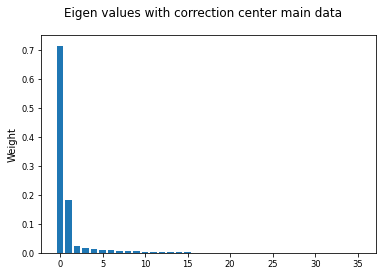

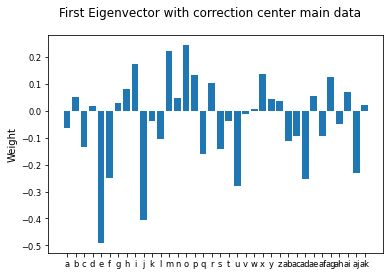

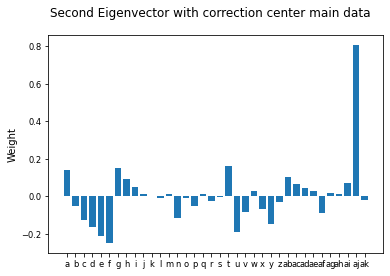

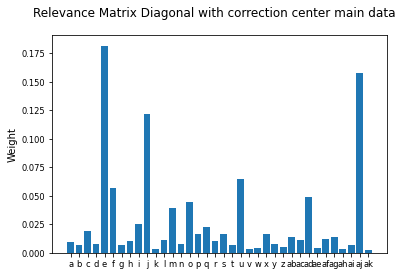

In [20]:
ploteigenvalues(eigenvaluescenter,eigenvectorscenter,average_lambda_center,'center')

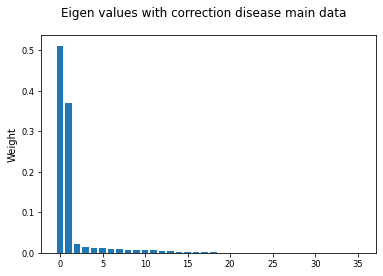

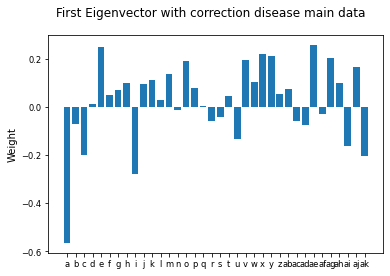

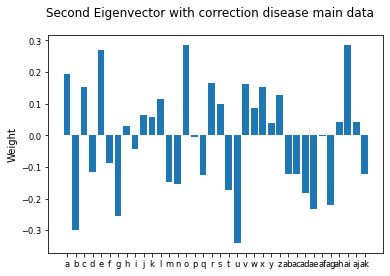

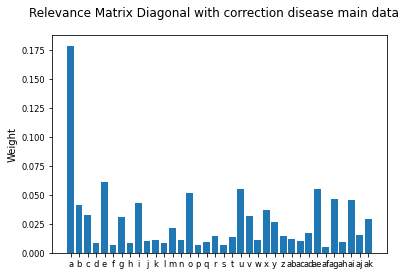

In [21]:
ploteigenvalues(eigenvaluesdisease,eigenvectorsdisease,average_lambda_disease,'disease')

In [ ]:
# removing the z transform
def visualize(model,scaler):
    
    data = scaler.inverse_transform(data)
    transformed_data = model.transform(data, scale=True)

    x_d = transformed_data[:, 0]
    y_d = transformed_data[:, 1]

    # Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
    # prototype inverser transform
    prototypes = scaler.inverse_transform(model1.prototypes_)

    transformed_model1 = model1.transform(prototypes, scale=True)

    print(len(model1.prototypes_))
    x_m = transformed_model1[:, 0]
    y_m = transformed_model1[:, 1]

    fig, ax = plt.subplots()
    fig.suptitle("Maindataset disease data with corresponding prototypes")
    colors = ['yellow','Magenta','brown']#,'pink','lightgreen']
    for i, cls in enumerate(model1.classes_):
        ii = cls == labels
        ax.scatter(
            x_d[ii],
            y_d[ii],
            c=colors[i],
            s=100,
            alpha=0.7,
            edgecolors="white",
            label=model1.classes_[model1.prototypes_labels_[i]],
        )
    ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
    ax.set_xlabel("First eigenvector")
    ax.set_ylabel("Second eigenvector")
    ax.legend()
    ax.grid(True)
    print(model1.classes_)
    plt.savefig('disease.png')
    #plt.savefig('destination_path23.eps', format='eps')
    print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [ ]:
print(modellist[1])